# Make "red" noise, by specifying the decay scale for an exponentially decaying autocorrelation. 

## How do you choose that scale? 
Reasoning: 

AR1 "Red" noise has covariance that drops off exponentially with lag. So if C0 is the variance of the series, and C1 the covariance at a one-step lag, we want to know the value of $\tau_{efold}$ for which $C1/C0 = exp(\delta t / \tau_{efold})$. Solving, $$\tau_{efold} = \delta t /ln(C1/C0) = \delta t /ln(r1)$$ where $r1$ is the *autocorrelation at lag 1.* 


### Use this principle: 
"The Fourier transform of an autocorrelation function is the power spectrum." 
http://www.cv.nrao.edu/course/astr534/FourierTransforms.html

I am trying to use this principle, but **something is wrong here!!** The Fourier transform of a real series is complex, so how can that be a "power spectrum"? The real part is not positive definite, so that isn't it. 

### Work in a pylab session: clean basic tools

In [360]:
# This %pylab magic line loads numpy, scipy, matplotlib. 
# add the word inline to put figures inline
%pylab inline
# plt.xkcd();

Populating the interactive namespace from numpy and matplotlib


### From your data (which you are trying to mimic with noise), type 

corrcoef(y, roll(y,1)) 

to see the lag-1 value you need. The function roll(y,1) shifts an array y by one slot periodically. (This is careless about endpoint effects; if your series is short, you should be more careful.) 

In [361]:
# var(y) 
# corrcoef(y, roll(y,1))
# len(y)

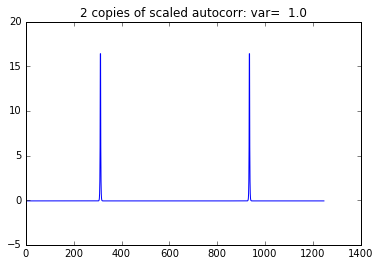

In [362]:
# Let's mimick a data array y, using AR1 red noise. 
# That only depends on autoregression at lag 1 (hence an "AR1 process")

# INPUTS: Nino 3.4 for 52 years has {0.96, 0.5, 624}
lag1_autocorr = 0.96  # Read off this value from corrcoef(y, roll(y,1))
variance = 1        # Read off this value from var(y) 
N = 624               # Read off this value from len(y)  

### CALCULATIONS AND PLOTTING
T_efold = 1.0/log(lag1_autocorr) # Units: number of array positions

### MAKE A YAUTO(X) ARRAY WITH THE RIGHT SIZE, VARIANCE, AND SPECTRUM
x = arange(N)              # A simple count array
xpert = x-mean(x)  
yauto = exp(- abs(xpert))  # Autocorrelation
# Scale it to have the given variance
yauto *= sqrt(variance/var(yauto))
# Remove the mean
yauto = detrend(yauto) 

### QUICK PLOT TO SEE IF IT IS SENSIBLE
xx = concatenate([x,x+max(x)])
plot(xx, concatenate([yauto,yauto]))
title('2 copies of scaled autocorr: var='+format(var(yauto),'5.3'));

## Make the complex spectrum, using fft
...normalizing by input series length, since science doesn't want the *values* of spectra to depend on N. 

In [363]:
N = len(yauto) 
spec = fft.fft(yauto) /N

# Unpack in all the usual ways: real (cos) and imaginary (sin)
specr = real(spec)
speci = imag(spec)

# Unpack in all the usual ways: amplitude and phase
ampli = abs(spec)
phase = angle(spec)

# But wait -- the Fourier transform of autocorrelation is POWER. Amplitude is sqrt(power). 

## Synthesize data. 
### 3 Methods: 
>1. assign random phase to the red power spectrum
>2. assign random amplitudes to the cos and sin (real and imaginary) amplitudes
>3. build time series as Markov chan

Repeated ctrl-enter in the following cell will make one new realization after another to look at. It is sobering with respect to, say, monthly climate records in the instrumental era (a few hundred months, autocorr = 0.96 for Nino3.4)

0.28
Variance:  1.06883536306 0.908781267343 0.854639924627 specified  1


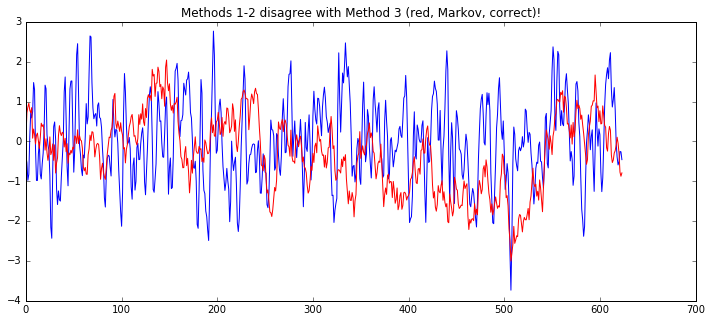

In [364]:
## Method 1: Randomize phase with uniform distribution in [0,2pi] range

syn_ampli = ampli # The amplitude array to work with
syn_phase = 2*pi*rand( len(phase) )
syn_spec =(    syn_ampli*cos(syn_phase)   #real part
         + 1j* syn_ampli*sin(syn_phase) ) #imag part

# Synthesize back into physical space (time domain) with real(ifft(spec)): 
# First, we have to rescale by N = len(y). 
###  synthesis has halved the variance! Let's fix it.
syn_data = real( ifft(syn_spec) ) *N 
syn_data1 = syn_data*sqrt(2)



## Method 2: Build synthetic spectrum from real and imaginary parts
syn_a = syn_ampli * randn( len(syn_ampli) ) /sqrt(2)
syn_b = syn_ampli * randn( len(syn_ampli) ) /sqrt(2)
syn_spec = syn_a + 1j*syn_b    
syn_data = real( ifft(syn_spec) ) *N 
syn_data2 = syn_data*sqrt(2)



# Method 3: Build time series from chain process
# https://en.wikipedia.org/wiki/Autoregressive_model
# Example: An AR(1) process
# If phi is the parameter of x(i) = phi*x(i-1) + noise
# then var(x) = var(noise)/(1-phi**2)
# and autocorrelation = phi

phi = lag1_autocorr
mag = sqrt( (1-phi**2)*variance )
print mag
syn_data3 = syn_data*0.0 # right sized array, now fill it

syn_data3[0] = rand()*mag
for i in arange(1,N):
    syn_data3[i] = syn_data3[i-1]*phi + randn()*mag


print 'Variance: ', var(syn_data1),var(syn_data2),var(syn_data3),  'specified ',variance
figure(1, figsize=[12,5])
plot(syn_data1,'b'); plot(syn_data3,'r')
title('Methods 1-2 disagree with Method 3 (red, Markov, correct)!')

## Let's take method 3

In [365]:
syn_data = syn_data3

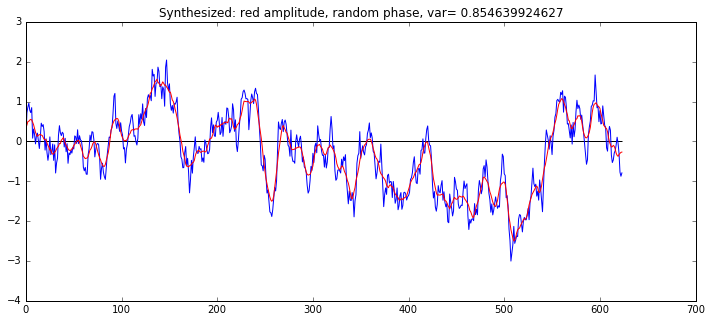

In [366]:
### PLOT the results
figure(6, figsize=[12,5])
yy = tile(syn_data,2)
# plot(xx,yy)
plot(x, syn_data)

# Overplot a smoothed version
kernel = N/10  # to emphasize lowest frequencies
yysmoo = np.convolve(yy, np.ones((10,))/10, mode='same')
ysmoo = np.convolve(syn_data, np.ones((10,))/10, mode='same')

#plot(xx, yysmoo, 'r', linewidth=3)
plot(x, ysmoo, 'r')

title('Synthesized: red amplitude, random phase, var= '+str(var(yy)) );
hlines(0,min(x),max(x));

In [367]:
var(yy)

0.85463992462700222

### Plot *spectra* of method 1 (randomized phase)

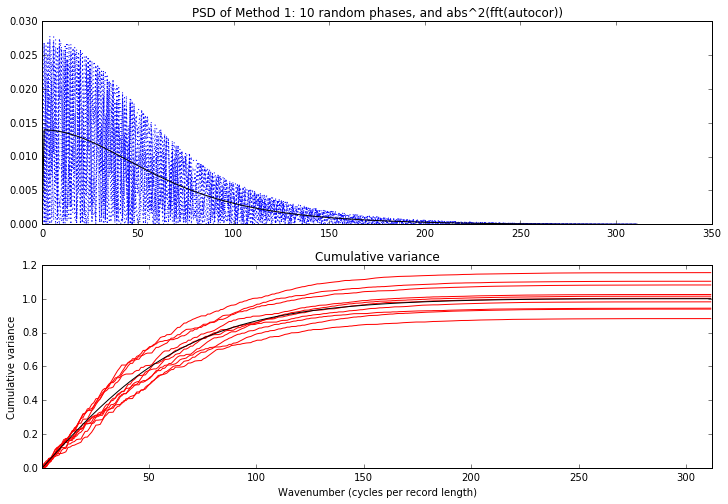

In [368]:
## Spectra of realizations with random phases
figure(7, figsize=[12,8])

N_SYN = 10

## Loop over realizations
for i in arange(N_SYN): 
    
# Make synthetic series of right variance 
    syn_phase = 2*pi*rand( len(phase) )
    syn_spec =(    syn_ampli*cos(syn_phase)   #real part
             + 1j* syn_ampli*sin(syn_phase) ) #imag part
    syn_data = real( ifft(syn_spec)*N ) *sqrt(2)

# fft of this one synthetic *realization*
    N = len(syn_data) 
    Wavenumbers = arange(N/2)
    realiz_spec = fft.fft(syn_data) /N
    realiz_ampli = abs(realiz_spec)

# DOUBLE THE VALUEs of half the symmetric spectrum (other than wavenumber 0)
# Power spectrum density is Amplitude squared
# But actually only 0.5x that, since var(sin(x))=var(cos(x))=0.5

    realiz_Amp = realiz_ampli[0:(N/2)] *2.
    realiz_Amp[0] = 0 # zero out the mean of the series
    realiz_Power = (realiz_Amp**2) *0.5

    subplot(211)
    plot(Wavenumbers,realiz_Power   , 'b:')
    title('PSD of Method 1: '+str(N_SYN)+' random phases, and abs^2(fft(autocor))')
    
# Cumulative power graph
    CumWavenum  = concatenate(([-0.5],arange(N/2)+0.5))
    CumVar      = concatenate(([0],   cumsum(realiz_Power) ))
                     
    subplot(212)
    plot(CumWavenum,CumVar,'r')
    xlim([0.5,N/2])
    title('Cumulative variance')
    xlabel('Wavenumber (cycles per record length)')
    ylabel('Cumulative variance');

    
# True spectrum in black, on top of red spaghetti
subplot(211)
Amp = ampli[0:(N/2)] *2.
Amp[0] = 0
Power = (Amp**2) *0.5
plot(Wavenumbers,Power, 'k' );

CumVar      = concatenate(([0],   cumsum(Power) ))
subplot(212)
plot(CumWavenum,CumVar,'k')


## The graphs above show that randomizing *phase* can only lead to sample peaks up to double the true red amplitude spectrum. 

### What if instead we synthesize data by using Gaussian random *amplitudes* of the real and imaginary components *separately*? (Method 2)

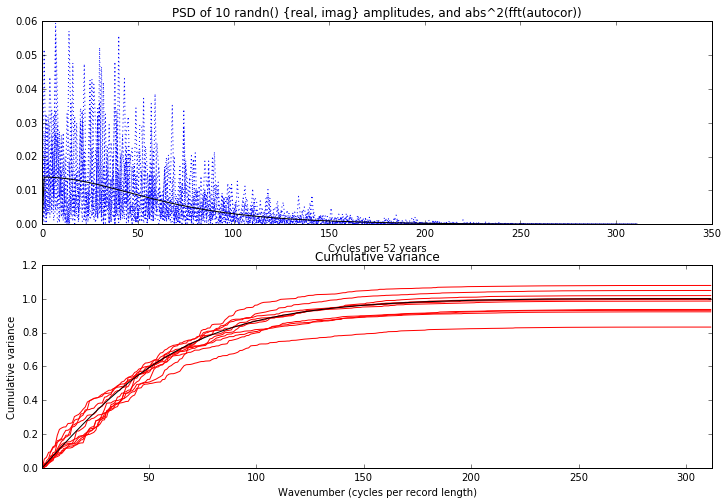

In [369]:
## Spectra of realizations with random AMPLITUDES OF REAL AND IMAG PARTS
figure(8, figsize=[12,8])
N_SYN = 10

## Loop over realizations
for i in arange(N_SYN): 
    
# Make synthetic series from 2 random amplitudes 
# randn() makes values with mean=0, stdev=1
# So divide by sqrt(2) so that the stdev of the complex amplitude will be 1
    syn_a = syn_ampli * randn( len(syn_ampli) ) /sqrt(2)
    syn_b = syn_ampli * randn( len(syn_ampli) ) /sqrt(2)
    syn_spec = syn_a + 1j*syn_b
    
    syn_data = real( ifft(syn_spec)*N ) *sqrt(2)

# fft of this one synthetic *realization*
    N = len(syn_data) 
    Wavenumbers = arange(N/2)
    realiz_spec = fft.fft(syn_data) /N
    realiz_ampli = abs(realiz_spec)

# DOUBLE THE VALUEs of half the symmetric spectrum (other than wavenumber 0)
# Power spectrum density is Amplitude squared
# But actually only 0.5x that, since var(sin(x))=var(cos(x))=0.5

    realiz_Amp = realiz_ampli[0:(N/2)] *2.
    realiz_Amp[0] = 0 # zero out the mean of the series
    realiz_Power = (realiz_Amp**2) *0.5

    
########## PLOTS
    subplot(211)
    plot(Wavenumbers,realiz_Power   , 'b:')
    title('PSD of '+str(N_SYN)+' randn() {real, imag} amplitudes, and abs^2(fft(autocor))')
    xlabel('Cycles per 52 years') # ; xlim([0,60]); 
    ('Power spectral density of red noises, and truth')

# Cumulative power graph
    CumWavenum  = concatenate(([-0.5],arange(N/2)+0.5))
    CumVar      = concatenate(([0],   cumsum(realiz_Power) ))
                     
    subplot(212)
    plot(CumWavenum,CumVar,'r')
    xlim([0.5,N/2])
    title('Cumulative variance')
    xlabel('Wavenumber (cycles per record length)')
    ylabel('Cumulative variance');

    
# True spectrum in black, on top of red spaghetti
subplot(211)
Amp = ampli[0:(N/2)] *2.
Amp[0] = 0
Power = (Amp**2) *0.5
plot(Wavenumbers,Power, 'k' );

CumVar      = concatenate(([0],   cumsum(Power) ))
subplot(212)
plot(CumWavenum,CumVar,'k')


## It shows that Method 2 line spectra are more variable than Method 1

## Better try Method 3 (Markov chain with lag-1 autocor)

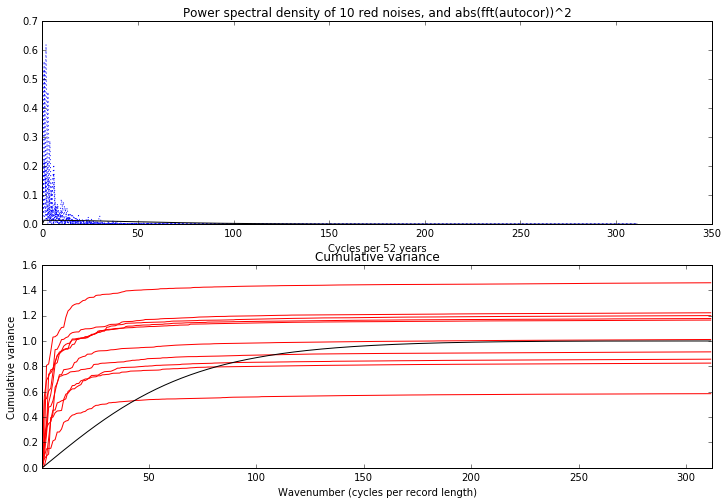

In [370]:
## Spectra of realizations from a Markov chain
figure(9, figsize=[12,8])
N_SYN = 10
    
# https://en.wikipedia.org/wiki/Autoregressive_model example AR1
phi = lag1_autocorr
mag = sqrt( (1-phi**2)*variance )
syn_data = syn_data*0.0 # right sized array, now fill it

## Loop over realizations
for i_syn in arange(N_SYN): 

    # synthesize data
    syn_data[0] = rand()*mag
    for i in arange(1,N):
        syn_data[i] = syn_data[i-1]*phi + randn()*mag

# fft of this one synthetic *realization*
    N = len(syn_data) 
    Wavenumbers = arange(N/2)
    realiz_spec = fft.fft(syn_data) /N
    realiz_ampli = abs(realiz_spec)

# DOUBLE THE VALUEs of half the symmetric spectrum (other than wavenumber 0)
# Power spectrum density is Amplitude squared
# But actually only 0.5x that, since var(sin(x))=var(cos(x))=0.5

    realiz_Amp = realiz_ampli[0:(N/2)] *2.
    realiz_Amp[0] = 0 # zero out the mean of the series
    realiz_Power = (realiz_Amp**2) *0.5

    
########## PLOTS
    subplot(211)
    plot(Wavenumbers,realiz_Power   , 'b:')
    title('Power spectral density of '+str(N_SYN)+' red noises, and abs(fft(autocor))^2')
    xlabel('Cycles per 52 years') # ; xlim([0,60]); 
    ('Power spectral density of red noises, and truth')

# Cumulative power graph
    CumWavenum  = concatenate(([-0.5],arange(N/2)+0.5))
    CumVar      = concatenate(([0],   cumsum(realiz_Power) ))
                     
    subplot(212)
    plot(CumWavenum,CumVar,'r')
    xlim([0.5,N/2])
    title('Cumulative variance')
    xlabel('Wavenumber (cycles per record length)')
    ylabel('Cumulative variance');

    
# The same old fft(autocor) spectrum in black, on top of the red spaghetti
subplot(211)
Amp = ampli[0:(N/2)] *2.
Amp[0] = 0
Power = (Amp**2) *0.5
plot(Wavenumbers,Power, 'k' );

CumVar      = concatenate(([0],   cumsum(Power) ))
subplot(212)
plot(CumWavenum,CumVar,'k')


# ARGGHHH there is a mistake in methods 1 and 2 